# Models
The following classification models are carried out here:
    1. Random Forest
    2. Nested Logit

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

# oversampling
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

Using TensorFlow backend.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Applications/anaconda/

# 1. Load in data

In [2]:
X_16 = pd.read_csv('../../Data/model_inputs/gdf_2016_X.csv')
y_16 = pd.read_csv('../../Data/model_inputs/gdf_2016_y.csv')
X_17 = pd.read_csv('../../Data/model_inputs/gdf_2017_X.csv')
y_17 = pd.read_csv('../../Data/model_inputs/gdf_2017_y.csv')

In [3]:
X_17.columns

Index(['id_trip', 'mode', 'duration', 'distance_m', 'weekday', 'precip',
       'temp', 'morning', 'midday', 'afternoon', 'evening', 'midnight',
       'startx', 'starty', 'endx', 'endy'],
      dtype='object')

In [4]:
def boolean_to_num(row):
    if row:
        return 1
    else:
        return 0
if not type(X_16['morning'][0]) == np.int64:
    print('changing booleans to numbers')
    for col in ['morning','midday','afternoon','evening','midnight']:
        X_16[col] = X_16[col].apply(boolean_to_num)
        X_17[col] = X_17[col].apply(boolean_to_num)

changing booleans to numbers


##### Dependent variable class sizes
Purpose: {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
Mode: {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5}

In [5]:
print('Dependent variable class sizes 2016:')
y_16['purpose'].value_counts()

Dependent variable class sizes 2016:


0    7430
1    5790
2    5682
3    2473
4    2262
5    2168
Name: purpose, dtype: int64

In [6]:
print('Dependent variable class sizes 2017:')
y_17['purpose'].value_counts()

Dependent variable class sizes 2017:


0    8049
2    7723
1    2714
4    2175
3    1379
5     908
Name: purpose, dtype: int64

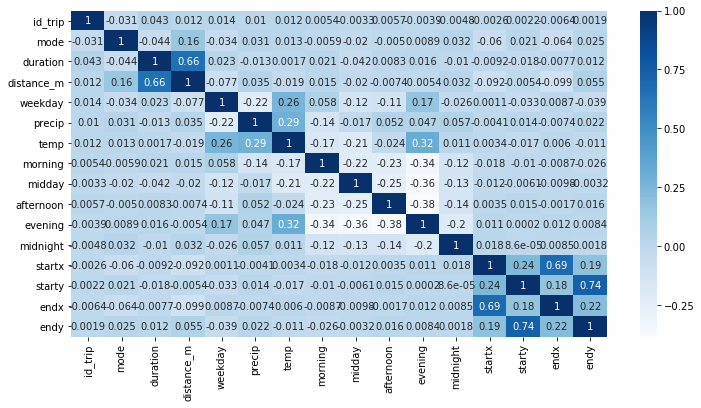

In [7]:
ax, fig = plt.subplots(1, figsize=(12,6))
sns.heatmap(X_16.corr(), cmap='Blues', annot=True)

# 2. Setup model
#### Section Overview:
2.1  Split data into training and testing  
2.2  Calculate p_nearby
2.3  Remove trip ID's from train/test data  

In [8]:
combined_X = pd.concat([X_16, X_17],axis=0)
combined_y = pd.concat([y_16, y_17],axis=0)
combined_X.reset_index(drop=True, inplace=True)
combined_y.reset_index(drop=True, inplace=True)

In [9]:
# check for no duplicates
combined_X.id_trip.value_counts()

67583      1
3196210    1
2379075    1
23873      1
2598206    1
          ..
3488209    1
2013826    1
3580545    1
2271872    1
466134     1
Name: id_trip, Length: 48753, dtype: int64

In [10]:
# check for no duplicates
combined_y.purpose.value_counts()

0    15479
2    13405
1     8504
4     4437
3     3852
5     3076
Name: purpose, dtype: int64

In [11]:
# define main data
all_X = combined_X.copy()
all_y = combined_y.copy()

### 2.1 Split data into training and testing

In [12]:
def normalise(X, to_normalize):
    """
        Feature scaling method.
        Normalises an array between 0–1 using the Z-score
        (i - min) / (max - min)
    """
    for col in X.columns[to_normalize]:
        row_min = X[col].min()
        row_max = X[col].max()
        X[col] = X[col].apply(lambda row: (row - row_min)/(row_max - row_min))
    return X
    

def model_setup(X, y, test_size=0.33, norm=False, to_normalise=[]):
    """
        All operations needed for preparing the model inputs.
        Can apply normalisation and then will apply the train/test split
    """
    if norm:
        X = normalise(X, to_normalise)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=test_size,\
                                                                                random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test    

##### IMPORTANT
Train Test Split for encoded and non-encoded

In [13]:
non_categorical_features = [False,False,True,True,False,True,True,False,False,False,\
                            False,False,False,False,False,False]


In [14]:
all_X.columns[non_categorical_features]

Index(['duration', 'distance_m', 'precip', 'temp'], dtype='object')

In [15]:
# Train Test Split
X_train, X_test, y_train, y_test  = model_setup(all_X, all_y, norm=True, test_size=0.33, to_normalise=non_categorical_features)



In [16]:
X_train.head()

,id_trip,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,evening,midnight,startx,starty,endx,endy
13051,3592784,2,0.015505,0.015059,1,0.018937,0.333150,0,0,1,0,0,7.629479e+06,1.254025e+06,7.629632e+06,1.252537e+06
37551,152350,2,0.048111,0.034086,1,0.035834,0.775837,0,0,0,0,1,7.619616e+06,1.265810e+06,7.620944e+06,1.265901e+06
7582,1959960,2,0.156737,0.138435,0,0.509026,0.415893,0,0,0,1,0,7.627604e+06,1.244069e+06,7.616296e+06,1.245143e+06
48160,204665,2,0.126010,0.027076,1,0.292437,0.418278,0,0,0,1,0,7.626442e+06,1.249992e+06,7.627373e+06,1.251307e+06
30591,123314,3,0.077711,0.031316,1,0.000076,0.513285,0,1,0,0,0,7.629966e+06,1.246249e+06,7.631133e+06,1.244680e+06


## 2.2 Calculate p_nearby
Proportion of other trips that ended nearby with a given purpose

Purpose: {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}


In [17]:
# initialise the geo dataframes needed
all_X['geometry'] = all_X.apply(lambda row: shapely.geometry.Point(row['endx'],row['endy']),axis=1)
geo_df = gpd.GeoDataFrame(pd.concat([all_X,all_y],axis=1))
geo_df.crs = {'init':'epsg:3347'} # Canada Lambert Projection

In [18]:
# only purposes of points around training are known  
all_train = pd.concat([X_train,pd.DataFrame(y_train, columns=['purpose'])],axis=1)
geo_X_train = all_train.copy()
geo_X_train.reset_index(drop=True,inplace=True)

In [19]:
geo_X_train['geometry'] = geo_X_train.apply(lambda row: shapely.geometry.Point(row['endx'],row['endy']),axis=1)
geo_df_train = gpd.GeoDataFrame(geo_X_train)
geo_df_train.crs = {'init':'epsg:3347'}

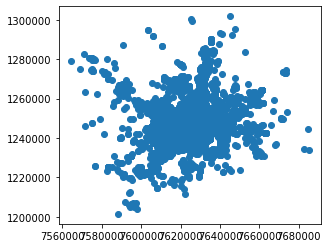

In [20]:
geo_df_train.plot()

In [21]:
# calculate 200 m buffers around each trip end point
geo_df['buffers'] = geo_df['geometry'].apply(lambda row: row.buffer(200))

In [22]:
# get dataframe with only buffers and purposes
all_buffers = geo_df[['id_trip','buffers','purpose']]
geo_df.drop('buffers',axis=1,inplace=True)
all_buffers = gpd.GeoDataFrame(all_buffers.rename(columns={'buffers':'geometry'}))
all_buffers.crs = {'init': 'epsg:3347'}

In [23]:
%%time
joined_data = gpd.sjoin(all_buffers, geo_df_train, op='intersects', how='left')

CPU times: user 25.7 s, sys: 1.54 s, total: 27.2 s
Wall time: 27.2 s


In [24]:
print(len(joined_data))
joined_data.tail()

2219087


,id_trip_left,geometry,purpose_left,index_right,id_trip_right,mode,duration,distance_m,weekday,precip,...,morning,midday,afternoon,evening,midnight,startx,starty,endx,endy,purpose_right
48752,333364,"POLYGON ((7614336.832987056 1237383.977932147,...",2,1577.0,176152.0,2.0,0.116050,0.063887,1.0,0.081351,...,0.0,0.0,0.0,1.0,0.0,7.616309e+06,1.234206e+06,7.614149e+06,1.237374e+06,2.0
48752,333364,"POLYGON ((7614336.832987056 1237383.977932147,...",2,7936.0,50177.0,2.0,0.059293,0.025514,0.0,0.009972,...,0.0,0.0,0.0,1.0,0.0,7.613771e+06,1.238383e+06,7.614149e+06,1.237374e+06,2.0
48752,333364,"POLYGON ((7614336.832987056 1237383.977932147,...",2,14898.0,2048905.0,3.0,0.012028,0.006100,1.0,0.023530,...,0.0,1.0,0.0,0.0,0.0,7.614512e+06,1.237863e+06,7.614135e+06,1.237383e+06,0.0
48752,333364,"POLYGON ((7614336.832987056 1237383.977932147,...",2,6401.0,2209132.0,2.0,0.100357,0.025408,1.0,0.221659,...,0.0,0.0,0.0,1.0,0.0,7.615460e+06,1.238870e+06,7.614135e+06,1.237383e+06,4.0
48752,333364,"POLYGON ((7614336.832987056 1237383.977932147,...",2,24234.0,27836.0,2.0,0.220259,0.340667,1.0,0.003005,...,0.0,0.0,0.0,0.0,1.0,7.639030e+06,1.244346e+06,7.614137e+06,1.237384e+06,0.0


In [25]:
%%time
to_drop = joined_data[['id_trip_left','id_trip_right']].apply(lambda row: True \
                                                                if row['id_trip_left'] == row['id_trip_right']\
                                                                else False, axis=1)

CPU times: user 43.2 s, sys: 75.6 ms, total: 43.2 s
Wall time: 43.3 s


In [26]:
to_drop[:5]

0    False
0    False
0    False
0    False
0    False
dtype: bool

In [27]:
# get rid of duplicate trips
joined_data = joined_data[~to_drop]

In [28]:
# see if duplicates have been dropped (check if more than one trip ID shows)
joined_data.loc[joined_data['id_trip_left'] == 2386427]

,id_trip_left,geometry,purpose_left,index_right,id_trip_right,mode,duration,distance_m,weekday,precip,...,morning,midday,afternoon,evening,midnight,startx,starty,endx,endy,purpose_right
21325,2386427,"POLYGON ((7617980.68002283 1251490.953635346, ...",2,26384.0,7311.0,2.0,0.137286,0.170948,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,7.627867e+06,1.248470e+06,7.617872e+06,1.251486e+06,5.0


In [29]:
grouped_data = joined_data.groupby(['id_trip_left', 'purpose_right']).agg({'mode':'count'})
grouped_data = grouped_data.unstack().apply(lambda row: row/row.sum(),axis=1)['mode'].reset_index()
grouped_data = grouped_data.fillna(0.0)
# rename columns
grouped_data.columns = ['id_trip','p_nearby_leisure','p_nearby_food','p_nearby_shops','p_nearby_pickup','p_nearby_education',\
                       'p_nearby_health']

In [30]:
print('num of trips without other trips around:', all_X['id_trip'].nunique() - grouped_data['id_trip'].nunique())

num of trips without other trips around: 2386


In [31]:
grouped_data.head()

,id_trip,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,7,0.244681,0.244681,0.308511,0.021277,0.138298,0.042553
1,21,0.378378,0.108108,0.297297,0.162162,0.000000,0.054054
2,67,0.076923,0.000000,0.615385,0.153846,0.076923,0.076923
3,86,0.235294,0.200000,0.341176,0.094118,0.023529,0.105882
4,115,0.307692,0.000000,0.307692,0.230769,0.076923,0.076923


In [32]:
# join the data back to the all_X
if not 'p_nearby_leisure' in all_X.columns:
    print('merging')
    all_X = all_X.merge(grouped_data, on='id_trip', how='left')
    all_X = all_X.fillna(0.0)

merging


In [33]:
if 'geometry' in all_X.columns:
    print('removing geometry')
    all_X.drop('geometry', axis=1, inplace=True)

removing geometry


In [34]:
all_X.head(2)

,id_trip,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,...,startx,starty,endx,endy,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,1889461,1,0.036365,0.017995,1,0.004090,0.893262,0,0,0,...,7.632056e+06,1.247584e+06,7.630298e+06,1.248129e+06,0.455556,0.088889,0.388889,0.011111,0.022222,0.033333
1,2071991,3,0.073670,0.027212,1,0.043444,0.870440,0,0,0,...,7.628002e+06,1.247761e+06,7.626230e+06,1.247150e+06,0.727273,0.045455,0.045455,0.000000,0.045455,0.136364


### 2.2.1 re-join the props back to train test

In [35]:
if not 'p_nearby_leisure' in X_train.columns:
    print('merging data')
    col_to_merge = ['id_trip', 'p_nearby_leisure','p_nearby_food','p_nearby_shops',\
                        'p_nearby_pickup','p_nearby_education','p_nearby_health']
    X_train = X_train.merge(all_X[col_to_merge], on='id_trip')
    X_test = X_test.merge(all_X[col_to_merge], on='id_trip')

merging data


In [36]:
X_train.head()

,id_trip,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,...,startx,starty,endx,endy,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,3592784,2,0.015505,0.015059,1,0.018937,0.333150,0,0,1,...,7.629479e+06,1.254025e+06,7.629632e+06,1.252537e+06,0.000000,0.250000,0.250000,0.250000,0.250000,0.000000
1,152350,2,0.048111,0.034086,1,0.035834,0.775837,0,0,0,...,7.619616e+06,1.265810e+06,7.620944e+06,1.265901e+06,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000
2,1959960,2,0.156737,0.138435,0,0.509026,0.415893,0,0,0,...,7.627604e+06,1.244069e+06,7.616296e+06,1.245143e+06,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000
3,204665,2,0.126010,0.027076,1,0.292437,0.418278,0,0,0,...,7.626442e+06,1.249992e+06,7.627373e+06,1.251307e+06,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000
4,123314,3,0.077711,0.031316,1,0.000076,0.513285,0,1,0,...,7.629966e+06,1.246249e+06,7.631133e+06,1.244680e+06,0.130682,0.130682,0.153409,0.039773,0.505682,0.039773


In [37]:
X_test.head()

,id_trip,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,...,startx,starty,endx,endy,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,2715767,2,0.032043,0.021728,0,0.078174,0.367638,0,0,1,...,7.625899e+06,1.249168e+06,7.624254e+06,1.249322e+06,0.666667,0.166667,0.000000,0.166667,0.000000,0.000000
1,2403724,1,0.017008,0.021340,1,0.000031,0.466932,0,0,0,...,7.632835e+06,1.271211e+06,7.633464e+06,1.273263e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,444946,3,0.089457,0.025674,1,0.000046,0.660308,0,0,0,...,7.631953e+06,1.246781e+06,7.631104e+06,1.244594e+06,0.195489,0.120301,0.135338,0.030075,0.481203,0.037594
3,3127597,2,0.009397,0.011322,1,0.021394,0.282052,1,0,0,...,7.633023e+06,1.238315e+06,7.632900e+06,1.239433e+06,0.131579,0.236842,0.263158,0.210526,0.052632,0.105263
4,3396409,5,0.074140,0.019809,1,0.000061,0.396925,1,0,0,...,7.630482e+06,1.241910e+06,7.631047e+06,1.243823e+06,0.239796,0.163265,0.096939,0.015306,0.428571,0.056122


## 2.3  Remove trip ID's and coords
...as these are not needed for the analysis, but are used later to identify trips and do oversampling

In [38]:
# keep coords
X_train_coords = X_train[['id_trip','startx','starty','endx','endy']]
X_test_coords = X_test[['id_trip','startx','starty','endx','endy']]

# drop unneeded features
X_train = X_train.drop(['startx','starty','endx','endy'],axis=1)
X_test = X_test.drop(['startx','starty','endx','endy'],axis=1)

In [39]:
# keep training ids
training_ids = X_train['id_trip'].copy()
X_train = X_train.drop('id_trip', axis=1)
testing_ids = X_test['id_trip'].copy()
X_test = X_test.drop('id_trip', axis=1)


In [40]:
X_train.columns

Index(['mode', 'duration', 'distance_m', 'weekday', 'precip', 'temp',
       'morning', 'midday', 'afternoon', 'evening', 'midnight',
       'p_nearby_leisure', 'p_nearby_food', 'p_nearby_shops',
       'p_nearby_pickup', 'p_nearby_education', 'p_nearby_health'],
      dtype='object')

In [41]:
## flatten data i.e. from Pd.Series to np.array
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [42]:
feature_list = list(X_train.columns)
print('all_features:\n\n', feature_list)

all_features:

 ['mode', 'duration', 'distance_m', 'weekday', 'precip', 'temp', 'morning', 'midday', 'afternoon', 'evening', 'midnight', 'p_nearby_leisure', 'p_nearby_food', 'p_nearby_shops', 'p_nearby_pickup', 'p_nearby_education', 'p_nearby_health']


In [43]:
X_train.columns

Index(['mode', 'duration', 'distance_m', 'weekday', 'precip', 'temp',
       'morning', 'midday', 'afternoon', 'evening', 'midnight',
       'p_nearby_leisure', 'p_nearby_food', 'p_nearby_shops',
       'p_nearby_pickup', 'p_nearby_education', 'p_nearby_health'],
      dtype='object')

In [44]:
# needed for CV scores
reduced_X = all_X.copy()
reduced_X = reduced_X.drop(['id_trip','startx','starty','endx','endy'],axis=1)

# 3. Begin Modelling
#### Section Overview:
3.1 Define model functions and test modelling   
3.2 Preliminary modelling for important feature extraction  
3.3 Re-run models  

#### Model functions:
- `run_rf` == run the random forest classification model.
- `run_logit` == run the nested classification model.

#### Notes:

#### Technical Notes:
- each model will have a cross-validation option. To use this the function parameters will need to be set to `cv=True` and `cv_val` to the number of k-folds defaulting to `cv_val=10`

### 3.1 Define model functions and test

In [45]:
# All Model functions
def run_rf(X_train, X_test, y_train, y_test, n_estimators=128):
    """
        Run a random forest classification model with option to use cross-validation
    """
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    score = clf.score(X_test,y_test)
    preds = clf.predict(X_test)
    print("Random Forest Classifcation accuracy:", score)
    return clf, score, preds

def shuffle_data(X,y):
    shuffled_data = pd.concat([X, y],axis=1)
    shuffled_data = sklearn.utils.shuffle(shuffled_data)
    shuffled_data = shuffled_data.reset_index(drop=True)
    shuffled_X = shuffled_data[shuffled_data.columns[shuffled_data.columns != 'purpose']]
    shuffled_y = shuffled_data[['purpose']]
    return shuffled_X, shuffled_y

#### 3.1.1 test models

In [46]:
%%time
rf_clf, rf_score, rf_preds = run_rf(X_train, X_test, y_train, y_test)

Random Forest Classifcation accuracy: 0.5064329666231587
CPU times: user 9.41 s, sys: 147 ms, total: 9.55 s
Wall time: 9.58 s


In [47]:
shuffled_X, shuffled_y = shuffle_data(reduced_X,all_y)

In [48]:
shuffled_X.head()

,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,evening,midnight,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,0,0.107874,0.011425,1,0.001275,0.389820,0,0,0,0,1,0.357143,0.171429,0.214286,0.085714,0.071429,0.100000
1,1,0.200808,0.078077,1,0.000031,0.353266,0,1,0,0,0,0.282353,0.258824,0.176471,0.011765,0.223529,0.047059
2,1,0.301353,0.108815,1,0.000137,0.257360,1,0,0,0,0,0.260870,0.318841,0.231884,0.028986,0.072464,0.086957
3,2,0.038433,0.025281,0,0.009622,0.592349,0,0,0,1,0,0.326087,0.108696,0.086957,0.434783,0.043478,0.000000
4,0,0.088423,0.010505,1,0.082340,0.308516,0,1,0,0,0,0.000000,0.500000,0.250000,0.000000,0.250000,0.000000


In [49]:
print('predictions for each class by RF:', collections.Counter(rf_preds), '\n')
# {'leisure': 0, 'food_drink': 1, 'shops': 2,
# 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
print(sklearn.metrics.classification_report(y_test, rf_preds))

predictions for each class by RF: Counter({0: 6976, 2: 4973, 1: 1982, 4: 1236, 5: 464, 3: 458}) 

              precision    recall  f1-score   support

           0       0.50      0.69      0.58      5108
           1       0.42      0.29      0.34      2807
           2       0.51      0.57      0.54      4424
           3       0.41      0.15      0.22      1271
           4       0.69      0.58      0.63      1464
           5       0.50      0.23      0.31      1015

    accuracy                           0.51     16089
   macro avg       0.51      0.42      0.44     16089
weighted avg       0.50      0.51      0.49     16089



In [50]:
%%time
rf_cv_scores = sklearn.model_selection.cross_val_score(rf_clf,shuffled_X, np.ravel(shuffled_y), cv=5)

CPU times: user 51.8 s, sys: 967 ms, total: 52.8 s
Wall time: 52.9 s


In [51]:
rf_cv_scores

array([0.5256844 , 0.52348236, 0.51846154, 0.51671795, 0.51651621])

### 3.2 Subset data by feature importance metric

In [52]:
def feature_selection(model, X_train, X_test, y_train, y_test, threshold):
    model.fit(X_train, y_train)
    print("model score before feature extraction: ", model.score(X_test, y_test))
    perm = PermutationImportance(model).fit(X_test, y_test)
    
    
    # perm.feature_importances_ attribute is now available, it can be used
    # for feature selection - let's e.g. select features which increase
    # accuracy by at least 0.01:
    X_train_subset = X_train[X_train.columns[perm.feature_importances_ > threshold]]
    X_test_subset = X_test[X_test.columns[perm.feature_importances_ > threshold]]
    
    return model, X_train_subset, X_test_subset, perm
    

In [53]:
## EXAMPLE OF USE
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=128, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
perm = PermutationImportance(clf).fit(X_test, y_test)
# perm.feature_importances_ attribute is now available, it can be used
# for feature selection - let's e.g. select features which increase
# accuracy by at least 0.01:
sel = SelectFromModel(perm, threshold=0.01, prefit=True)
X_test.columns[perm.feature_importances_ > 0.01]

0.5079246690285288


Index(['mode', 'distance_m', 'weekday', 'temp', 'midnight', 'p_nearby_leisure',
       'p_nearby_food', 'p_nearby_shops', 'p_nearby_education'],
      dtype='object')

In [54]:
%%time
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=128, n_jobs=-1)
clf, X_train_subset, X_test_subset, perm = feature_selection(clf, X_train, X_test, y_train, y_test,threshold=0.01)
eli5.show_weights(perm)

model score before feature extraction:  0.5079246690285288
CPU times: user 1min 31s, sys: 2.51 s, total: 1min 33s
Wall time: 36.4 s


Weight,Feature
0.0481 ± 0.0038,x13
0.0435 ± 0.0024,x0
0.0420 ± 0.0025,x15
0.0297 ± 0.0024,x10
0.0287 ± 0.0024,x3
0.0275 ± 0.0034,x5
0.0223 ± 0.0040,x11
0.0172 ± 0.0044,x2
0.0133 ± 0.0035,x12
0.0106 ± 0.0021,x14


In [55]:
print('important columns:\n',X_test.columns[[0,5,10,3,15,2,13,4]])

important columns:
 Index(['mode', 'temp', 'midnight', 'weekday', 'p_nearby_education',
       'distance_m', 'p_nearby_shops', 'precip'],
      dtype='object')


In [56]:
X_train_subset.head()

,mode,distance_m,weekday,temp,midnight,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education
0,2,0.015059,1,0.333150,0,0.000000,0.250000,0.250000,0.250000,0.250000
1,2,0.034086,1,0.775837,1,0.500000,0.000000,0.000000,0.000000,0.000000
2,2,0.138435,0,0.415893,0,0.000000,0.500000,0.000000,0.500000,0.000000
3,2,0.027076,1,0.418278,0,0.500000,0.500000,0.000000,0.000000,0.000000
4,3,0.031316,1,0.513285,0,0.130682,0.130682,0.153409,0.039773,0.505682


In [57]:
sel = SelectFromModel(perm, threshold=0.01, prefit=True)

In [58]:
subset_shuffled_X = sel.transform(shuffled_X)
subset_shuffled_X = pd.DataFrame(subset_shuffled_X, columns=X_train_subset.columns)

In [59]:
subset_shuffled_X.head(1)

,mode,distance_m,weekday,temp,midnight,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education
0,0.0,0.011425,1.0,0.38982,1.0,0.357143,0.171429,0.214286,0.085714,0.071429


In [60]:
## re-shuffle
subset_shuffled_X, shuffled_y = shuffle_data(subset_shuffled_X, shuffled_y)

In [61]:
subset_shuffled_X.head(1)

,mode,distance_m,weekday,temp,midnight,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education
0,2.0,0.085189,1.0,0.324407,0.0,0.285714,0.285714,0.214286,0.0,0.071429


### 3.3 Re-build the models with new subset data

#### Note:

purpose = {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}  

In [62]:
rf_clf, rf_score, rf_preds = run_rf(X_train_subset, X_test_subset, y_train, y_test)

Random Forest Classifcation accuracy: 0.4808875629311952


In [63]:
print('predictions for each class by RF:', collections.Counter(rf_preds), '\n')
# {'leisure': 0, 'food_drink': 1, 'shops': 2,
# 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
print(sklearn.metrics.classification_report(y_test, rf_preds))

predictions for each class by RF: Counter({0: 6844, 2: 4886, 1: 2132, 4: 1235, 3: 514, 5: 478}) 

              precision    recall  f1-score   support

           0       0.49      0.66      0.56      5108
           1       0.38      0.29      0.33      2807
           2       0.49      0.54      0.51      4424
           3       0.33      0.14      0.19      1271
           4       0.65      0.55      0.60      1464
           5       0.42      0.20      0.27      1015

    accuracy                           0.48     16089
   macro avg       0.46      0.40      0.41     16089
weighted avg       0.47      0.48      0.46     16089



In [64]:
%%time
rf_cv_scores = sklearn.model_selection.cross_val_score(rf_clf,subset_shuffled_X, np.ravel(shuffled_y), cv=5)

CPU times: user 47.7 s, sys: 1.19 s, total: 48.9 s
Wall time: 49.5 s


In [65]:
rf_cv_scores

array([0.51286784, 0.50697293, 0.50707692, 0.51076923, 0.50133361])

# 4 Improve models
### Overview:
4.1 Encode model inputs (for ANN/SVC)   
4.2 Re-run models with encoded inputs  
4.3 Oversample  
4.4 add POI categories to model  

### 4.1 Encode model inputs
The model inputs are encoded to improve the performance of ANN/SVC models. Specifically by One-hot encoding all the 

#### Encoded inputs:
- Trip mode *(f)*
- Cardinal Direction *(f)*
- Trip starting & ending cluster from K-means (see `./Notebooks/preprocessing/metric_creation/clustering.ipynb`)
- Temporal cluster from LDA
- Land-use at trip starting and ending points *(f)* (see `./Notebooks/preprocessing/metric_creation/land_use_poi.ipynb`)

*(f) == factors*

#### Note:
- for factor numbers see Data/model_inputs folder e.g. `./Data/model_inputs/gdf_2016_land_use_factors.txt`

In [66]:
# for One Hot Encoded data
enc_X_train = X_train.copy()
enc_X_test = X_test.copy()
enc_y_train = pd.DataFrame(y_train, columns=['purpose']).copy()
enc_y_test = pd.DataFrame(y_test, columns=['purpose']).copy()

In [67]:
def encode_model_inputs(data, col):
    """
        function for applying a OneHotEncoder to a input feature 
    """
    encoded_input = ''
    if col in data.columns:
        encoded_input = enc.fit_transform(data[col].values.reshape(-1, 1)).toarray()
    return encoded_input


In [68]:
enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')


In [69]:
encoded_inputs_train = {}
encoded_inputs_test = {}
for col in ["mode"]:
    if col in enc_X_train.columns:
        # 1. encode inputs
        encoded_inputs_train[col] = encode_model_inputs(enc_X_train, col)
        encoded_inputs_test[col] = encode_model_inputs(enc_X_test, col)
        # 2. make a temporary df with encoded inputs and column names of format *col*_*factor*
        col_df_train = pd.DataFrame(encoded_inputs_train[col], columns=['%s_%s' % (col, i) for i in range(encoded_inputs_train[col].shape[1])])
        col_df_test = pd.DataFrame(encoded_inputs_test[col], columns=['%s_%s' % (col, i) for i in range(encoded_inputs_test[col].shape[1])])
        # 3. drop column from main data so that they can be concatenated
        enc_X_train = enc_X_train.drop(col, axis=1)
        enc_X_test = enc_X_test.drop(col, axis=1)
        # 4. concatenate the two data sets
        enc_X_train = pd.concat([enc_X_train, col_df_train], axis=1)
        enc_X_test = pd.concat([enc_X_test, col_df_test], axis=1)

encoded_inputs_train['purpose'] = encode_model_inputs(enc_y_train, 'purpose')
encoded_inputs_test['purpose'] = encode_model_inputs(enc_y_test, 'purpose')

In [70]:
# view new data with columns following the *col*_*factor* syntax
enc_X_train.columns

Index(['duration', 'distance_m', 'weekday', 'precip', 'temp', 'morning',
       'midday', 'afternoon', 'evening', 'midnight', 'p_nearby_leisure',
       'p_nearby_food', 'p_nearby_shops', 'p_nearby_pickup',
       'p_nearby_education', 'p_nearby_health', 'mode_0', 'mode_1', 'mode_2',
       'mode_3', 'mode_4', 'mode_5'],
      dtype='object')

In [71]:
rf_clf, rf_score, rf_preds = run_rf(enc_X_train, enc_X_test, enc_y_train, enc_y_test)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Random Forest Classifcation accuracy: 0.5084840574305426


In [72]:
print('predictions for each class by RF:', collections.Counter(rf_preds), '\n')
# {'leisure': 0, 'food_drink': 1, 'shops': 2,
# 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
print(sklearn.metrics.classification_report(y_test, rf_preds))

predictions for each class by RF: Counter({0: 6884, 2: 5023, 1: 2042, 4: 1224, 3: 463, 5: 453}) 

              precision    recall  f1-score   support

           0       0.51      0.68      0.58      5108
           1       0.42      0.31      0.36      2807
           2       0.51      0.58      0.54      4424
           3       0.41      0.15      0.22      1271
           4       0.70      0.58      0.63      1464
           5       0.51      0.23      0.32      1015

    accuracy                           0.51     16089
   macro avg       0.51      0.42      0.44     16089
weighted avg       0.50      0.51      0.49     16089



In [73]:
all_enc_X = pd.concat([enc_X_train,enc_X_test],axis=0).reset_index(drop=True)
all_enc_y = pd.concat([enc_y_train, enc_y_test],axis=0).reset_index(drop=True)

In [74]:
all_enc_X.tail()

,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,evening,midnight,...,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health,mode_0,mode_1,mode_2,mode_3,mode_4,mode_5
48748,0.025559,0.007380,1,0.081366,0.617143,0,0,0,1,0,...,0.288462,0.038462,0.038462,0.096154,0.0,1.0,0.0,0.0,0.0,0.0
48749,0.086450,0.129731,1,0.379206,0.696968,0,0,0,0,1,...,0.388889,0.166667,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
48750,0.097444,0.049527,1,0.294600,0.588271,0,1,0,0,0,...,0.350000,0.050000,0.200000,0.050000,0.0,0.0,1.0,0.0,0.0,0.0
48751,0.040124,0.008617,0,0.136399,0.770588,0,0,0,0,1,...,0.112195,0.014634,0.434146,0.053659,0.0,0.0,0.0,1.0,0.0,0.0
48752,0.011182,0.008249,1,0.000000,0.400937,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0


In [75]:
shuffled_enc_X, shuffled_enc_y = shuffle_data(all_enc_X, all_enc_y)

In [76]:
shuffled_enc_X.tail()

,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,evening,midnight,...,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health,mode_0,mode_1,mode_2,mode_3,mode_4,mode_5
48748,0.274948,0.579247,1,0.000000,0.230876,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
48749,0.098384,0.008433,1,0.000046,0.571037,0,0,0,1,0,...,0.120000,0.120000,0.120000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
48750,0.475662,0.021104,0,0.000015,0.915131,0,0,0,1,0,...,0.142857,0.000000,0.000000,0.285714,1.0,0.0,0.0,0.0,0.0,0.0
48751,0.050742,0.016651,1,0.000379,0.669221,0,0,0,1,0,...,0.258065,0.043011,0.053763,0.010753,0.0,0.0,0.0,1.0,0.0,0.0
48752,0.105525,0.013910,0,0.194482,0.301818,0,0,0,1,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0


In [77]:
rf_cv_scores = sklearn.model_selection.cross_val_score(rf_clf,shuffled_enc_X, np.ravel(shuffled_enc_y), cv=5)

In [78]:
rf_cv_scores

array([0.52414642, 0.51753486, 0.52051282, 0.52594872, 0.5172343 ])

# 4.3 Oversample
## 4.3.1 Load in data

In [79]:
# define all categorical/nominal features
categorical_features = [True,False,False,True,False,False,True,True,True,True,True,False,False,False,False]
ros = SMOTENC(categorical_features, random_state=0)

In [80]:
X_train_with_ID = pd.concat([pd.DataFrame(training_ids, columns=['id_trip']),X_train],axis=1)

In [81]:
%%time
oversampled_X_train, oversampled_y_train = ros.fit_resample(X_train_with_ID, y_train)


CPU times: user 1min 49s, sys: 2.95 s, total: 1min 52s
Wall time: 1min 52s


In [82]:
# check if oversampling worked
print('Before:\n',collections.Counter(y_train))
print('After:\n',collections.Counter(oversampled_y_train))

Before:
 Counter({0: 10371, 2: 8981, 1: 5697, 4: 2973, 3: 2581, 5: 2061})
After:
 Counter({1: 10371, 0: 10371, 4: 10371, 2: 10371, 3: 10371, 5: 10371})


In [83]:
oversampled_X_train = pd.DataFrame(oversampled_X_train, columns=X_train_with_ID.columns)

In [84]:
oversampled_X_train.head()

,id_trip,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,evening,midnight,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,3592784.0,2.0,0.015505,0.015059,1.0,0.018937,0.333150,0.0,0.0,1.0,0.0,0.0,0.000000,0.250000,0.250000,0.250000,0.250000,0.000000
1,152350.0,2.0,0.048111,0.034086,1.0,0.035834,0.775837,0.0,0.0,0.0,0.0,1.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000
2,1959960.0,2.0,0.156737,0.138435,0.0,0.509026,0.415893,0.0,0.0,0.0,1.0,0.0,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000
3,204665.0,2.0,0.126010,0.027076,1.0,0.292437,0.418278,0.0,0.0,0.0,1.0,0.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000
4,123314.0,3.0,0.077711,0.031316,1.0,0.000076,0.513285,0.0,1.0,0.0,0.0,0.0,0.130682,0.130682,0.153409,0.039773,0.505682,0.039773


In [85]:
oversampled_X_train['id_trip'].value_counts()

3593194.0    66
3472482.0    62
3254598.0    58
3587543.0    52
3432071.0    47
             ..
2786168.0     1
3067273.0     1
155998.0      1
413812.0      1
7.0           1
Name: id_trip, Length: 32664, dtype: int64

In [86]:
# view new data
oversampled_X_train.loc[oversampled_X_train['id_trip'] == 3593194].head(10)

,id_trip,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,evening,midnight,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
27689,3593194.0,1.0,0.097726,0.011529,0.0,0.063846,0.349079,0.0,1.0,0.0,0.0,0.0,0.322581,0.137097,0.346774,0.056452,0.040323,0.096774
54072,3593194.0,1.0,0.193531,0.006294,0.0,0.257855,0.433107,0.0,0.0,0.0,0.0,0.0,0.377986,0.262540,0.226514,0.031647,0.037023,0.064291
54135,3593194.0,1.0,0.115669,0.006294,0.0,0.051208,0.324251,0.0,1.0,0.0,0.0,0.0,0.323285,0.197678,0.287249,0.070486,0.036319,0.084984
54156,3593194.0,1.0,0.045646,0.000171,0.0,0.073643,0.349079,0.0,1.0,0.0,0.0,0.0,0.306264,0.121980,0.322539,0.037975,0.027125,0.184117
54165,3593194.0,1.0,0.022661,0.000171,0.0,0.080634,0.349079,0.0,1.0,0.0,0.0,0.0,0.280061,0.108719,0.326158,0.011524,0.034573,0.238965
54340,3593194.0,1.0,0.098096,0.006294,0.0,0.063585,0.324251,0.0,1.0,0.0,0.0,0.0,0.322595,0.138345,0.345548,0.056741,0.040240,0.096531
54412,3593194.0,1.0,0.096725,0.000171,0.0,0.231828,0.349079,0.0,1.0,0.0,0.0,0.0,0.272238,0.082760,0.517170,0.026382,0.046879,0.054571
54450,3593194.0,1.0,0.224860,0.006294,0.0,0.165566,0.433107,0.0,0.0,0.0,0.0,0.0,0.375626,0.265515,0.210714,0.045293,0.033534,0.069318
54468,3593194.0,1.0,0.130781,0.006294,0.0,0.022884,0.324251,0.0,1.0,0.0,0.0,0.0,0.383012,0.262383,0.140525,0.058459,0.076987,0.078634
54548,3593194.0,1.0,0.068636,0.006294,0.0,0.025704,0.324251,0.0,1.0,0.0,0.0,0.0,0.373855,0.269497,0.255854,0.036652,0.010283,0.053859


In [87]:
oversampled_training_ids = oversampled_X_train['id_trip']
oversampled_X_train.drop('id_trip',axis=1,inplace=True)

In [88]:
all_train = pd.concat([oversampled_X_train, pd.DataFrame(oversampled_y_train, columns=['purpose'])],axis=1)

In [89]:
## shuffle data
all_train = sklearn.utils.shuffle(all_train)

In [90]:
all_train.head()

,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,evening,midnight,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health,purpose
36434,2.0,0.254897,0.018511,1.0,0.000697,0.307329,1.0,0.0,0.0,0.0,0.0,0.087653,0.149576,0.693496,0.000000,0.043733,0.025542,1
54230,0.0,0.107228,0.004985,0.0,0.344161,0.672741,0.0,0.0,0.0,0.0,0.0,0.058899,0.058899,0.657970,0.044174,0.014725,0.165333,5
33264,1.0,0.159594,0.019566,1.0,0.242414,0.650088,0.0,0.0,0.0,0.0,1.0,0.221843,0.189954,0.422427,0.061382,0.066697,0.037696,1
4111,0.0,0.122251,0.006015,1.0,0.081366,0.585484,0.0,0.0,0.0,0.0,1.0,0.391304,0.130435,0.217391,0.130435,0.043478,0.086957,2
18334,2.0,0.065025,0.021385,0.0,0.000015,0.881692,0.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,2


In [91]:
oversampled_y_train = all_train['purpose']
oversampled_X_train = all_train.drop('purpose',axis=1)

## flatten data i.e. from Pd.Series to np.array
oversampled_y_train = np.ravel(oversampled_y_train)

In [92]:
%%time
over_rf_clf, over_rf_score, over_rf_preds = run_rf(oversampled_X_train, X_test, oversampled_y_train, y_test)

Random Forest Classifcation accuracy: 0.48660575548511403
CPU times: user 19.4 s, sys: 198 ms, total: 19.6 s
Wall time: 19.7 s


In [93]:
print('predictions for each class by RF:', collections.Counter(over_rf_preds), '\n')
# {'leisure': 0, 'food_drink': 1, 'shops': 2,
# 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
print(sklearn.metrics.classification_report(y_test, over_rf_preds))

predictions for each class by RF: Counter({0: 5780, 2: 4253, 1: 2506, 4: 1531, 5: 1062, 3: 957}) 

              precision    recall  f1-score   support

           0       0.53      0.60      0.56      5108
           1       0.39      0.34      0.36      2807
           2       0.53      0.51      0.52      4424
           3       0.29      0.22      0.25      1271
           4       0.60      0.63      0.62      1464
           5       0.32      0.34      0.33      1015

    accuracy                           0.49     16089
   macro avg       0.44      0.44      0.44     16089
weighted avg       0.48      0.49      0.48     16089



In [94]:
a = pd.concat([pd.DataFrame(oversampled_y_train, columns=['purpose']), \
                                pd.DataFrame(y_test, columns=['purpose'])]).reset_index()

In [95]:
b = pd.concat([oversampled_X_train,X_test]).reset_index()

In [96]:
shuffled_X, shuffled_y = shuffle_data(a,b)

In [97]:
rf_cv_scores = sklearn.model_selection.cross_val_score(rf_clf,shuffled_X, np.ravel(shuffled_y), cv=5)

In [98]:
rf_cv_scores

array([0.69620172, 0.6936287 , 0.69214071, 0.69761205, 0.69810357])

# under-sampling

In [99]:
rus = RandomUnderSampler(random_state=0)

In [100]:
undersampled_X_train, undersampled_y_train = rus.fit_resample(X_train_with_ID, y_train)

In [101]:
undersampled_X_train

array([[4.14767000e+05, 3.00000000e+00, 3.88084946e-02, ...,
        3.09278351e-02, 3.09278351e-02, 3.09278351e-02],
       [1.05433000e+05, 3.00000000e+00, 1.62187559e-01, ...,
        9.09090909e-02, 0.00000000e+00, 9.09090909e-02],
       [9.64800000e+04, 0.00000000e+00, 1.03364029e-02, ...,
        7.93650794e-03, 3.17460317e-02, 7.93650794e-03],
       ...,
       [2.43224600e+06, 2.00000000e+00, 1.77598196e-02, ...,
        1.70212766e-01, 8.51063830e-02, 4.25531915e-02],
       [2.01502500e+06, 3.00000000e+00, 1.19996241e-01, ...,
        0.00000000e+00, 7.69230769e-02, 7.69230769e-02],
       [3.46492100e+06, 2.00000000e+00, 9.94174027e-02, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000000e-01]])

In [102]:
undersampled_X_train = pd.DataFrame(undersampled_X_train, columns=X_train_with_ID.columns)

In [103]:
undersampled_training_ids = undersampled_X_train['id_trip']

In [104]:
undersampled_X_train.drop('id_trip',axis=1,inplace=True)

In [105]:
%%time
under_rf_clf, under_rf_score, under_rf_preds = run_rf(undersampled_X_train, X_test,\
                                                                      undersampled_y_train, y_test)

Random Forest Classifcation accuracy: 0.43240723475666604
CPU times: user 4.04 s, sys: 101 ms, total: 4.14 s
Wall time: 4.3 s


In [106]:
print('predictions for each class by RF:', collections.Counter(under_rf_preds), '\n')
# {'leisure': 0, 'food_drink': 1, 'shops': 2,
# 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
print(sklearn.metrics.classification_report(y_test, under_rf_preds))

predictions for each class by RF: Counter({0: 3723, 2: 3603, 1: 2770, 3: 2180, 5: 1927, 4: 1886}) 

              precision    recall  f1-score   support

           0       0.55      0.40      0.46      5108
           1       0.36      0.35      0.36      2807
           2       0.54      0.44      0.49      4424
           3       0.22      0.38      0.28      1271
           4       0.53      0.68      0.59      1464
           5       0.25      0.47      0.32      1015

    accuracy                           0.43     16089
   macro avg       0.41      0.45      0.42     16089
weighted avg       0.47      0.43      0.44     16089



## Problems:
1. oversampling doesn't know to estimate one binary for morning, afternoon etc.
2. oversampling will affect p_nearby

In [107]:
# fin